In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
seed = 1228

In [67]:
from mlxtend.classifier import StackingCVClassifier
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Preprocessing for PCA, LDA

In [5]:
def reverse_dummy(df_dummy):
    x = df_dummy.stack()
    return pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

soils = [
    [7, 15, 8, 14, 16, 17,
     19, 20, 21, 23], #unknow and complex 
    [3, 4, 5, 10, 11, 13],   # rubbly
    [6, 12],    # stony
    [2, 9, 18, 26],      # very stony
    [1, 24, 25, 27, 28, 29, 30,
     31, 32, 33, 34, 36, 37, 38, 
     39, 40, 22, 35], # extremely stony and bouldery
]


soil_dict = dict()
for index, values in enumerate(soils):
    for v in values:
        soil_dict[str(v)] = str(index)
        
def direction(x):
    if (x >=0 and x < 22.5) or (x>=337.5 and x<=360) :
        return 'N'
    elif (x>=22.5 and x<67.5):
        return 'NE'
    elif (x>=67.5 and x<112.5):
        return 'E'
    elif (x>=112.5 and x<157.5):
        return 'SE'
    elif (x>=157.5 and x<202.5):
        return 'S'
    elif (x>=202.5 and x<247.5):
        return 'SW'
    elif (x>=247.5 and x<292.5):
        return 'W'
    elif (x>=292.5 and x<337.5):
        return 'NW'

In [6]:

def preprocessing5(df1, drop_soil = False, drop_num = False):
    '''preserve soil type'''
    df = df1.copy()
    df['Wilderness_Area'] = reverse_dummy(df[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3','Wilderness_Area4']])
    df['Soil_Type'] = reverse_dummy(df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
    df.drop(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4','Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], axis = 1, inplace = True)
    
    df['Aspect_dir'] = df['Aspect'].apply(direction)
    df.drop(['Id','Aspect'], axis = 1, inplace = True)
    dumm = pd.get_dummies(df[['Wilderness_Area','Aspect_dir','Soil_Type']])   
    df = pd.concat([df, dumm], axis = 1).drop(['Wilderness_Area','Aspect_dir','Soil_Type'], axis = 1)
    
    return df

In [7]:
def get_train_test(train, test):
    X_train = preprocessing5(train).drop('Cover_Type', axis = 1)
    y = train['Cover_Type']
    X_test = preprocessing5(test).drop(['Soil_Type_Soil_Type15','Soil_Type_Soil_Type7'], axis = 1)
    # Soil_Type15 and  Soil_Type7 not in training set
    return X_train, y, X_test

In [8]:
X_train, y, X_test = get_train_test(train, test)

In [19]:
# study the soil_types
# previous preprocessing for tree models
# for later combine some features

def preprocessing4(df1, drop_soil = False, drop_num = False):
    '''preserve soil type'''
    df = df1.copy()
    df['Soil_Type'] = reverse_dummy(df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
    if drop_num == False:
        
        df['Soil_num'] = df['Soil_Type'].apply(lambda x:x[9:])
    
    df["Aspect_dir"] = df['Aspect'].apply(direction)
    df['Hydro_Ele_diff'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
    df['Hydro-Euclidean'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 +
                                   df['Vertical_Distance_To_Hydrology']**2)
    df['Hydro_Fire_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_diff'] = df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Road_sum'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways']
                                                
    df.drop(['Id','Aspect','Soil_Type'], axis = 1, inplace = True)
    dumm = pd.get_dummies(df['Aspect_dir'])
    df = pd.concat([df, dumm], axis = 1).drop(['Aspect_dir'], axis = 1)
    if drop_soil:
        df.drop(['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], axis = 1, inplace = True)
        return df
    else:         
        return df

In [20]:
train4 = preprocessing4(train)
test4 = pe=preprocessing4(test)

### Pipelines for PCA

In [9]:
# return PCA-included train, test

def get_princomp( train_set, test_set, connect = True):
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('pca', PCA(random_state = seed))])
    x1=train_set.select_dtypes(include='int64')
    x2=test_set.select_dtypes(include = 'int64')
    if connect:
        prin = pipe.fit_transform(pd.concat([x1,x2]))
        prin_train = pd.DataFrame(prin[:train_set.shape[0],:], columns=['comp'+str(i) for i in range(1,10)])
        prin_test = pd.DataFrame(prin[train_set.shape[0]:,:], columns=['comp'+str(i) for i in range(1,10)])
        print('Explaned var for Connected: ', np.cumsum(pipe.steps[1][1].explained_variance_ratio_))
    else:
        prin_train = pd.DataFrame(pipe.fit_transform(x1), columns=['comp'+str(i) for i in range(1,10)])
        prin_test = pd.DataFrame(pipe.transform(x2), columns=['comp'+str(i) for i in range(1,10)])
        print('Explaned var for Unconnected: ', np.cumsum(pipe.steps[1][1].explained_variance_ratio_))
    
    X_train_prin = pd.concat([train_set, prin_train], axis = 1)
    X_test_prin = pd.concat([test_set, prin_test], axis = 1)
    return X_train_prin, X_test_prin
    


In [10]:
X_train_prin, X_test_prin = get_princomp(X_train, X_test)

Explaned var for Connected:  [0.24750169 0.4653033  0.65600465 0.77528836 0.86060403 0.92099093
 0.96499975 0.99962194 1.        ]


In [11]:
print(X_train_prin.shape)
print(X_test_prin.shape)

(15120, 68)
(565892, 68)


##### CV results Using previous successful tree models 

In [13]:
models = {
    'LGBM': LGBMClassifier(n_estimators=500,  
                           num_leaves=100,
                           random_state=seed, 
                           metric = 'multi_logloss', 
                           n_jobs = -1, 
                           verbosity=0), 
    'Random Forest': RandomForestClassifier(n_estimators = 500, 
                                            max_features= 'auto',
                                            random_state=seed, 
                                            oob_score = True, 
                                            n_jobs=-1),
    'Extra Tree': ExtraTreesClassifier(n_estimators = 450, 
                                       n_jobs=-1, 
                                       random_state=seed,
                                       warm_start=True)}

clf = models['Random Forest']

def feature_importances(clf, X, y, edge):
    clf = clf.fit(X, y)
    
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(10,10))
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')
    
    c = importances.Importances >= edge
    cols = importances[c].Features.values
    
    return importances, cols


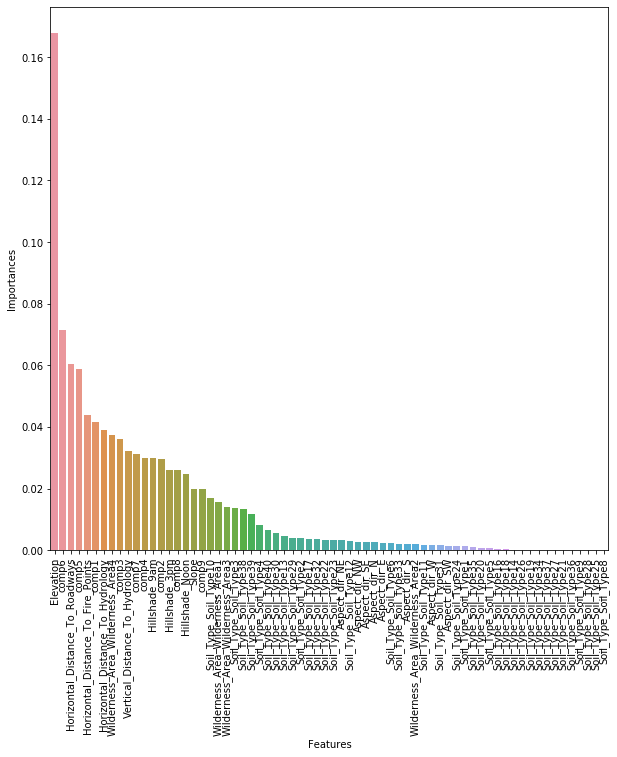

In [15]:
importances, cols = feature_importances(clf, X_train_prin, y, edge = 0.01)

In [16]:
cols

array(['Elevation', 'comp6', 'Horizontal_Distance_To_Roadways', 'comp5',
       'Horizontal_Distance_To_Fire_Points', 'comp1',
       'Horizontal_Distance_To_Hydrology',
       'Wilderness_Area_Wilderness_Area4', 'comp3',
       'Vertical_Distance_To_Hydrology', 'comp7', 'comp4',
       'Hillshade_9am', 'comp2', 'Hillshade_3pm', 'comp8',
       'Hillshade_Noon', 'Slope', 'comp9', 'Soil_Type_Soil_Type10',
       'Wilderness_Area_Wilderness_Area1',
       'Wilderness_Area_Wilderness_Area3', 'Soil_Type_Soil_Type3',
       'Soil_Type_Soil_Type38', 'Soil_Type_Soil_Type39'], dtype=object)

In [17]:

# model selection functions

def cross_val(models, X, y=y):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    r = dict()
    for name, model in models.items():
        cv_results = cross_val_score(model, X, y,
                             cv=cv, 
                             scoring='accuracy')
        r[name] = cv_results
        print(name, 'Accuracy Mean {0:.4f}, Std {1:.4f}'.format(
              cv_results.mean(), cv_results.std()))
    return r
    
# def choose_best(results):
#     errors = dict()

#     for name, arr in results.items():
#         errors[name] = arr.mean()

#     best_model =  [m for m, e in errors.items() 
#                    if e == max(errors.values())][0]
#     return best_model

In [18]:
results = cross_val(models, X=X_train_prin[cols], y = y)  
# not as good as previous feature engineering

LGBM Accuracy Mean 0.8629, Std 0.0042
Random Forest Accuracy Mean 0.8495, Std 0.0024
Extra Tree Accuracy Mean 0.8609, Std 0.0066


### LDA components

In [83]:
def get_lda(X_train, X_test, y, n_comp = None, key = None):
    '''
    for one key only
    return X_train, X_test directly
    '''
    scaler = StandardScaler()
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    
    if key == None:      
        X_n = X_train.select_dtypes(include = 'int64')
        X_n_t = X_test.select_dtypes(include = 'int64')
    else:
        col_s = X_train.columns[X_train.columns.str.contains(key)]
        X_n = X_train[col_s]
        X_n_t = X_test[col_s]
    y_c = pd.Categorical(y)

    lda_train = lda.fit_transform(scaler.fit_transform(X_n),y_c)
    lda_test = lda.transform(scaler.transform(X_n_t))
    k = lda_train.shape[1]
    lda_train = pd.DataFrame(lda_train, columns=['lda'+str(i) for i in range(1,k+1)])
    lda_test = pd.DataFrame(lda_test, columns=['lda'+str(i) for i in range(1,k+1)])
#     lda_test = pd.DataFrame(pipe.fit(X_n_t))
    print('Explained variance by LDA:',np.cumsum(lda.explained_variance_ratio_))
    print('Coef:', lda.coef_)
    X_train_lda = pd.concat([X_train, lda_train], axis = 1)
    X_test_lda = pd.concat([X_test, lda_test], axis = 1)
#     X_train_lda = pd.concat([train_set, lda_train], axis = 1)
#     X_test_lda = pd.concat([test_set, lda_test], axis = 1)
    
    return X_train_lda, X_test_lda

In [84]:
def get_lda_by(X_train, X_test, y, n_comp = None, by_key = None):
    '''
    get patial lda comp
    Specify keys to get lda components for selected columns
    '''
    scaler = StandardScaler()
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    
    if by_key == None:      
        X_n = X_train.select_dtypes(include = 'int64')
        X_n_t = X_test.select_dtypes(include = 'int64')
    else:
        col_s = X_train.columns[X_train.columns.str.contains(by_key)]
        X_n = X_train[col_s]
        X_n_t = X_test[col_s]
    y_c = pd.Categorical(y)

    lda_train = lda.fit_transform(scaler.fit_transform(X_n),y_c)
    lda_test = lda.transform(scaler.transform(X_n_t))
    k = lda_train.shape[1]
    lda_train = pd.DataFrame(lda_train, columns=[by_key+'_lda'+str(i) for i in range(1,k+1)])
    lda_test = pd.DataFrame(lda_test, columns=[by_key+'_lda'+str(i) for i in range(1,k+1)])
#     lda_test = pd.DataFrame(pipe.fit(X_n_t))
    print('Explained variance by LDA:',np.cumsum(lda.explained_variance_ratio_))
    print('Coef:', lda.coef_)
#     X_train_lda = pd.concat([X_train, lda_train], axis = 1)
#     X_test_lda = pd.concat([X_test, lda_test], axis = 1)
#     X_train_lda = pd.concat([train_set, lda_train], axis = 1)
#     X_test_lda = pd.concat([test_set, lda_test], axis = 1)
    
    return lda_train, lda_test

In [85]:
lda_train_dist, lda_test_dist = get_lda_by(X_train, X_test, y, 2, by_key = 'Distance')

Explained variance by LDA: [0.93262717 0.97141435]
Coef: [[ 0.604114   -0.53641231  0.84999081  0.29961895]
 [ 0.6328336  -0.44745803  0.58831376  0.56775434]
 [-0.39550741  0.45365243 -0.65660603 -0.49100079]
 [-0.9299553   0.39008728 -0.68580036 -0.54641915]
 [-0.16504907  0.10315988 -0.48155061  0.16727391]
 [-0.49150817  0.19601659 -0.59620296 -0.35042192]
 [ 0.74507235 -0.15904583  0.98185539  0.35319466]]


In [86]:
lda_train_hill, lda_test_hill = get_lda_by(X_train, X_test, y, 2, by_key = 'Hillshade')

Explained variance by LDA: [0.57776256 0.94041883]
Coef: [[ 1.76387957 -1.20423354  2.33245801]
 [ 1.20386368 -0.59047477  1.47998711]
 [-2.72089858  1.66284164 -2.99263353]
 [-1.59128581  1.62399052 -2.81563453]
 [-0.02125467  0.32103301 -0.54957737]
 [ 0.202864   -1.19412487  1.23616669]
 [ 1.1628318  -0.619032    1.30923362]]


##### Why LDA comp could be relevant?

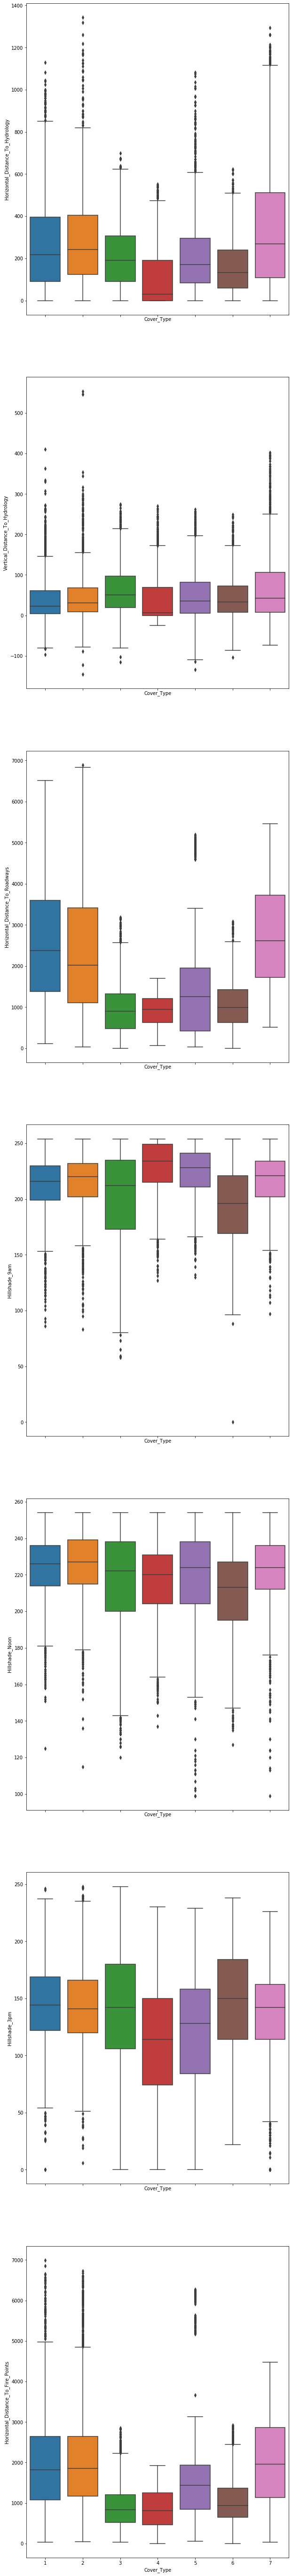

In [59]:
data2 = pd.concat([X_train.loc[:,X_train.columns.str.contains('Distance|Hillshade')], y], axis = 1)

f, axes = plt.subplots(data2.shape[1]-1, sharex = True, figsize = (10,100))
for j in range(data2.shape[1]-1):
    sns.boxplot(data = data2, x = 'Cover_Type', y = data2.columns[j], ax = axes[j])
del data2

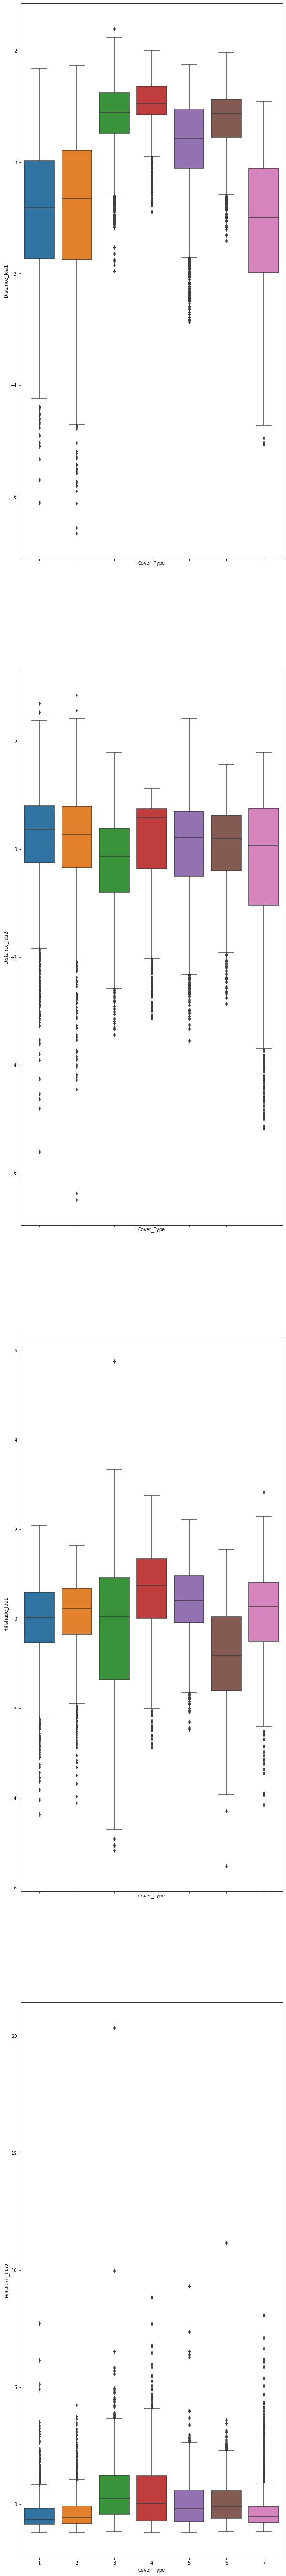

In [60]:
data1 = pd.concat([lda_train_dist, lda_train_hill, y], axis = 1)

f, axes = plt.subplots(data1.shape[1]-1, sharex = True, figsize = (10,100))
for j in range(data1.shape[1]-1):
    sns.boxplot(data = data1, x = 'Cover_Type', y = data1.columns[j], ax = axes[j])
del data1

# lda compo separates labels better than original features

##### Combine with original train/test set

In [30]:
def combine(X, *args):
    X_combined = pd.concat([X]+list(*args), axis = 1)
    return X_combined

- Combined with Soil_num, Hydro_Euclidean

In [34]:
X_train_comb = combine(X_train.loc[:,~X_train.columns.str.contains('Soil')], 
                       (lda_train_dist, lda_train_hill, 
                        train4['Soil_num'], train4['Hydro-Euclidean']))
X_test_comb = combine(X_test.loc[:,~X_train.columns.str.contains('Soil')], 
                      (lda_test_dist, lda_test_hill, 
                       test4['Soil_num'], test4['Hydro-Euclidean']))

,Features,Importances
0,Elevation,0.216569
25,Soil_num,0.139109
4,Horizontal_Distance_To_Roadways,0.071156
21,Distance_lda1,0.061169
8,Horizontal_Distance_To_Fire_Points,0.057394
23,Hillshade_lda1,0.049807
26,Hydro-Euclidean,0.041818
22,Distance_lda2,0.039148
12,Wilderness_Area_Wilderness_Area4,0.038387
2,Horizontal_Distance_To_Hydrology,0.036549


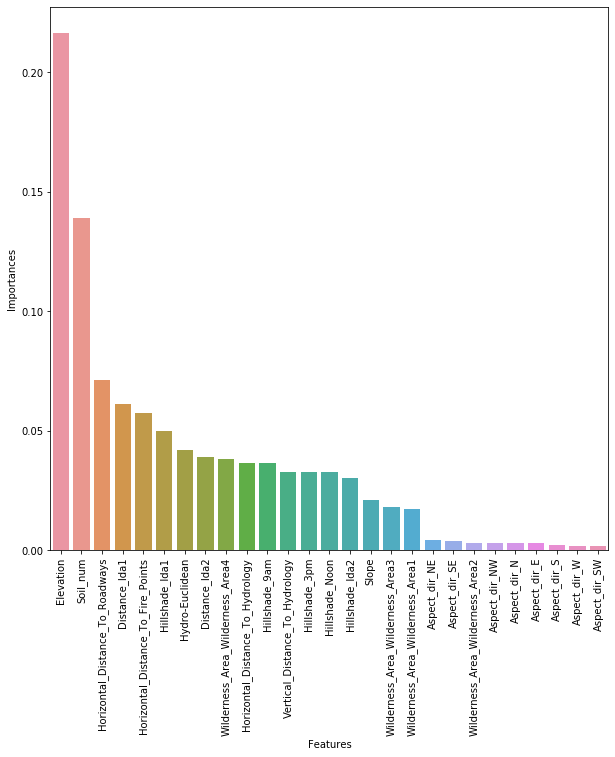

In [35]:
importances, cols = feature_importances(clf, X_train_comb, y, edge = 0.01)
importances

In [36]:
cross_val(models, X=X_train_comb[cols], y = y)  

LGBM Accuracy Mean 0.8747, Std 0.0048
Random Forest Accuracy Mean 0.8629, Std 0.0048
Extra Tree Accuracy Mean 0.8745, Std 0.0029


{'LGBM': array([0.87103175, 0.87202381, 0.86970899, 0.87929894, 0.88161376]),
 'Random Forest': array([0.86177249, 0.86210317, 0.85813492, 0.86044974, 0.87202381]),
 'Extra Tree': array([0.87433862, 0.87599206, 0.86937831, 0.87466931, 0.87830688])}

- Combined with train4

In [37]:
def choose_pp(m, *args, **args1):
    X_train = m(train, *args, **args1).drop('Cover_Type', axis = 1)
    y = train['Cover_Type'].astype('category')
    X_test = m(test, *args, **args1)
    X_train['Soil_num'] = X_train['Soil_num'].astype('int64')
    X_test['Soil_num'] = X_test['Soil_num'].astype('int64')
    return X_train, y, X_test
X_train4, y, X_test4 = choose_pp(preprocessing4, drop_soil = False, drop_num = False)
print(X_train4.shape)
print(X_test4.shape)

(15120, 67)
(565892, 67)


In [88]:
X_train_comb2 = combine(X_train4, (lda_train_dist, lda_train_hill))
X_test_comb2 = combine(X_test4, (lda_test_dist, lda_test_hill))
print(X_train_comb2.shape)
print(X_test_comb2.shape)

(15120, 71)
(565892, 71)


,Features,Importances
54,Hydro_Ele_diff,0.135515
0,Elevation,0.121110
53,Soil_num,0.085977
4,Horizontal_Distance_To_Roadways,0.044835
58,Hydro_Road_sum,0.043723
67,Distance_lda1,0.040770
69,Hillshade_lda1,0.035354
56,Hydro_Fire_sum,0.034791
8,Horizontal_Distance_To_Fire_Points,0.032439
57,Hydro_Fire_diff,0.031315


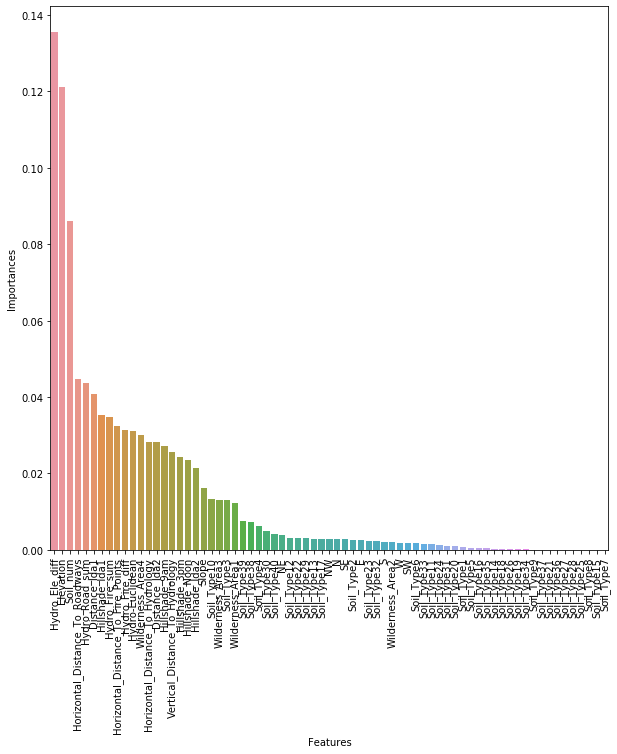

In [61]:
importances, cols = feature_importances(clf, X_train_comb2, y, edge = 0.01)
importances
# lda comp selected

In [62]:
cross_val(models, X=X_train_comb2[cols], y = y)
# cross_val results similar as no lda version

LGBM Accuracy Mean 0.8876, Std 0.0064
Random Forest Accuracy Mean 0.8764, Std 0.0052
Extra Tree Accuracy Mean 0.8922, Std 0.0044


{'LGBM': array([0.88425926, 0.88690476, 0.87929894, 0.88888889, 0.89880952]),
 'Random Forest': array([0.87863757, 0.87202381, 0.87400794, 0.87169312, 0.88558201]),
 'Extra Tree': array([0.89153439, 0.89285714, 0.8885582 , 0.88789683, 0.90013228])}

### Prediction and auto-save

In [65]:

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

best_model_name = 'Extra Tree'
best_model = models[best_model_name] # changed models

estimators = [m for m in models.values()]
stack = StackingCVClassifier(classifiers=estimators,
                             meta_classifier=best_model,
                             cv=cv,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=1,
                             random_state=seed,
                             n_jobs=-1)

Id = test['Id']

def predict(model, filename, X, y, test):
    model.fit(X, y)
    predicts = model.predict(test)

    output = pd.DataFrame({'Id': Id,
                       'Cover_Type': predicts})
    output.to_csv(filename+'.csv', index=False)
    return predicts

In [91]:
start_time = time.time()
predict_stack = predict(stack, 'submission12', X_train_comb2[cols], y=y, test = X_test_comb2[cols])
print("--- %s seconds ---" % (time.time() - start_time))

# 0.81568

Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   58.8s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: randomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: extratreesclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


--- 325.9714114665985 seconds ---
